In [1]:
from uncertainpy import Model

import numpy as np
from scipy.integrate import odeint


class HodgkinHuxley(Model):
    def __init__(self):
        Model.__init__(self,
                       interpolate=False,
                       labels=["Time (ms)", "Voltage (mV)"])

        ## HH Parameters
        self.V_rest = -65   # mV
        self.Cm = 1         # uF/cm**2
        self.gbar_Na = 120  # mS/cm**2
        self.gbar_K = 36    # mS/cm**2
        self.gbar_L = 0.3   # mS/cm**2
        self.E_Na = 50      # mV
        self.E_K = -77      # mV
        self.E_l = -54.4    # mV


        ## setup parameters and state variables
        self.I_value = 150
        T = 40    # ms
        dt = 0.025  # ms
        self.time = np.arange(0, T + dt, dt)



    def I(self, t):
        return self.I_value

    # K channel
    def alpha_n(self, V):
        return 0.01*(V + 55)/(1 - np.exp(-(V + 55)/10.))

    def beta_n(self, V):
        return 0.125*np.exp(-(V + 65)/80.)

    def n_f(self, n, V):
        return self.alpha_n(V)*(1 - n) - self.beta_n(V)*n

    def n_inf(self, V):
        return self.alpha_n(self.V_rest)/(self.alpha_n(self.V_rest) + self.beta_n(self.V_rest))


    # Na channel (activating)
    def alpha_m(self, V):
        return 0.1*(V + 40)/(1 - np.exp(-(V + 40)/10.))

    def beta_m(self, V):
        return 4*np.exp(-(V + 65)/18.)

    def m_f(self, m, V):
        return self.alpha_m(V)*(1 - m) - self.beta_m(V)*m

    def m_inf(self, V):
        return self.alpha_m(self.V_rest)/(self.alpha_m(self.V_rest) + self.beta_m(self.V_rest))


    # Na channel (inactivating)
    def alpha_h(self, V):
        return 0.07*np.exp(-(V + 65)/20.)

    def beta_h(self, V):
        return 1/(np.exp(-(V + 35)/10.) + 1)

    def h_f(self, h, V):
        return self.alpha_h(V)*(1 - h) - self.beta_h(V)*h

    def h_inf(self, V):
        return self.alpha_h(self.V_rest)/(self.alpha_h(self.V_rest) + self.beta_h(self.V_rest))


    def dXdt(self, X, t):
        V, h, m, n = X

        g_Na = self.gbar_Na*(m**3)*h
        g_K = self.gbar_K*(n**4)
        g_l = self.gbar_L

        dmdt = self.m_f(m, V)
        dhdt = self.h_f(h, V)
        dndt = self.n_f(n, V)

        dVdt = (self.I(t) - g_Na*(V - self.E_Na) - g_K*(V - self.E_K) - g_l*(V - self.E_l))/self.Cm

        return [dVdt, dhdt, dmdt, dndt]



    def run(self, **parameters):
        self.set_parameters(**parameters)

        self.h0 = self.h_inf(self.V_rest)
        self.m0 = self.m_inf(self.V_rest)
        self.n0 = self.n_inf(self.V_rest)

        initial_conditions = [self.V_rest, self.h0, self.m0, self.n0]
        
        X = odeint(self.dXdt, initial_conditions, self.time)
        
        values = X[:, 0]

         # Add info needed by certain spiking features and efel features
        info = {"stimulus_start": self.time[0], "stimulus_end": self.time[-1]}

        return self.time, values, info

In [2]:
import matplotlib.pyplot as plt
hh = HodgkinHuxley()
t0,v0,i0 = hh.run()
p = {'E_K':-76}
hh.set_parameters(**p)
t1,v1,i1 = hh.run()

In [3]:
i1

{'stimulus_end': 40.0, 'stimulus_start': 0.0}

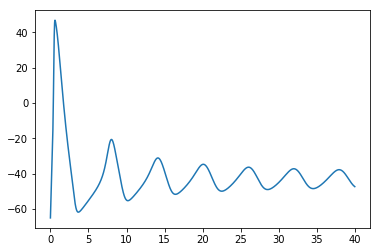

In [4]:
plt.plot(t0,v0)

In [5]:
import pyDOE
from scipy.stats.distributions import uniform

In [31]:
#Name, # Start of distribution, # Length of distribution
pc = 0.2 # Percent change

        
        
parameter_list = [
                  ["Cm", 1*(1-pc), 1*(1+pc) - 1*(1-pc)],
                  ["gbar_Na", 120*(1-pc) ,120*(1+pc) - 120*(1-pc)],
                  ["gbar_K" , 36*(1-pc) ,36*(1+pc) - 36*(1-pc)],
                  ["gbar_L" , 0.3*(1-pc),0.3*(1+pc) - 0.3*(1-pc)],
                  ["E_Na", 50*(1-pc), 50*(1+pc)-50*(1-pc)], 
                  ["E_K", -77*(1+pc), -77*(1-pc)- -77*(1+pc)], 
                  ["E_l", -54.4 *(1+pc), -54.4 *(1-pc)- -54.4 *(1+pc)]]

In [32]:
parameter_list

[['Cm', 0.8, 0.3999999999999999],
 ['gbar_Na', 96.0, 48.0],
 ['gbar_K', 28.8, 14.399999999999995],
 ['gbar_L', 0.24, 0.12],
 ['E_Na', 40.0, 20.0],
 ['E_K', -92.39999999999999, 30.79999999999999],
 ['E_l', -65.28, 21.759999999999998]]

In [33]:
parameter_list = np.array(parameter_list)

In [34]:
aa = [float(n) for n in parameter_list[:,1]]

In [35]:
aa

[0.8, 96.0, 28.8, 0.24, 40.0, -92.39999999999999, -65.28]

In [36]:
ab = [float(n) for n in parameter_list[:,2]]

In [37]:
ab

[0.3999999999999999,
 48.0,
 14.399999999999995,
 0.12,
 20.0,
 30.79999999999999,
 21.759999999999998]

In [38]:
un = uniform(aa,ab)

In [39]:
lh = pyDOE.lhs(7,samples=3**7)

In [40]:
sample_space = un.ppf(lh)

In [41]:
names = list(parameter_list[:,0])

In [42]:
names

['Cm', 'gbar_Na', 'gbar_K', 'gbar_L', 'E_Na', 'E_K', 'E_l']

In [43]:
param_space = []
for ss in sample_space:
    pp = {names[i]:v for i,v in enumerate(ss)}
    param_space.append(pp)

In [44]:
%%time
voltages = []
for pdict in param_space:
    hh = HodgkinHuxley()
    hh.set_parameters(**pdict)
    t,v,i = hh.run()
    voltages.append(v)
    

CPU times: user 3min 3s, sys: 922 ms, total: 3min 4s
Wall time: 3min 7s


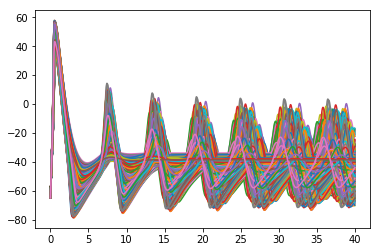

In [45]:
plt.plot(t,np.transpose(voltages));

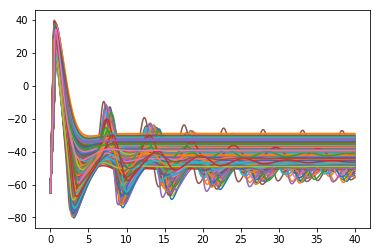

In [20]:
plt.plot(t,np.transpose(voltages));

In [49]:
np.shape(voltages)

(2187, 1601)

In [50]:
40/0.025

1600.0

In [51]:
vv = np.array(voltages)

In [52]:
ind = []
for v in vv:
    for i,vo in enumerate(v):
        if vo > 0:
            ind.append(i)
            break


In [53]:
np.mean(ind)*0.025

0.3955761316872428

In [54]:
import pandas as pd

In [55]:
col_names = [str(round(tt,3)) for tt in t0]

In [56]:
voltage_data = pd.DataFrame(voltages,columns=col_names)

In [57]:
voltage_data.head()

,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,...,39.775,39.8,39.825,39.85,39.875,39.9,39.925,39.95,39.975,40.0
0,-65.0,-61.701965,-58.447430,-55.233098,-52.054724,-48.906030,-45.777250,-42.653129,-39.510271,-36.313800,...,-55.988395,-55.783030,-55.578467,-55.374706,-55.171745,-54.969578,-54.768190,-54.567565,-54.367683,-54.168517
1,-65.0,-61.705495,-58.457036,-55.250977,-52.082800,-48.946108,-45.831257,-42.723459,-39.600250,-36.428239,...,-39.512404,-39.512407,-39.512409,-39.512412,-39.512415,-39.512417,-39.512420,-39.512423,-39.512425,-39.512428
2,-65.0,-60.836092,-56.737792,-52.698668,-48.710088,-44.758708,-40.822835,-36.867338,-32.837048,-28.649105,...,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445,-37.840445
3,-65.0,-60.726360,-56.523872,-52.385977,-48.303751,-44.263179,-40.241130,-36.199588,-32.077966,-27.783801,...,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636,-37.862636
4,-65.0,-61.771794,-58.593916,-55.463133,-52.375437,-49.325084,-46.303313,-43.296633,-40.284579,-37.236941,...,-30.735222,-30.758158,-30.802938,-30.869769,-30.958777,-31.070003,-31.203414,-31.358900,-31.536284,-31.735325


In [58]:
voltage_data.to_csv("/Users/larserikodegaard/../../Volumes/LE/Mas300/_data/HH_voltage_40s.csv")

In [59]:
aa

[0.8, 96.0, 28.8, 0.24, 40.0, -92.39999999999999, -65.28]

In [60]:
param_space

[{'Cm': 1.1075533381664453,
  'E_K': -92.25586495883074,
  'E_Na': 45.242184744503895,
  'E_l': -51.18213618853021,
  'gbar_K': 29.973817198046937,
  'gbar_L': 0.30656341271756526,
  'gbar_Na': 123.54254752950814},
 {'Cm': 1.1390930144628357,
  'E_K': -64.80630962993087,
  'E_Na': 56.577929619602955,
  'E_l': -64.96068397508098,
  'gbar_K': 37.57937171631717,
  'gbar_L': 0.28878051345715655,
  'gbar_Na': 104.79668581039681},
 {'Cm': 0.9328000598528234,
  'E_K': -62.628458255117195,
  'E_Na': 43.98528150276739,
  'E_l': -46.92014044710863,
  'gbar_K': 36.73179212478769,
  'gbar_L': 0.25116805385796925,
  'gbar_Na': 128.01808536105838},
 {'Cm': 0.9033426294059975,
  'E_K': -63.127635222401736,
  'E_Na': 59.79112449425878,
  'E_l': -50.711050385314365,
  'gbar_K': 35.36586112523305,
  'gbar_L': 0.2779784868654274,
  'gbar_Na': 102.77520223635628},
 {'Cm': 1.1273471209495105,
  'E_K': -88.31720024059891,
  'E_Na': 40.599923747653186,
  'E_l': -50.5389953496373,
  'gbar_K': 39.0511406562719

In [61]:
foo = param_space[0]

In [62]:
parameter_space = []
for p in param_space:
    parameter_space.append(list(p.values()))
    
parameter_space = np.array(parameter_space)

In [63]:
parameter_df = pd.DataFrame(parameter_space,columns=names)

In [64]:
parameter_df.head()

,Cm,gbar_Na,gbar_K,gbar_L,E_Na,E_K,E_l
0,123.542548,0.306563,-51.182136,1.107553,29.973817,45.242185,-92.255865
1,104.796686,0.288781,-64.960684,1.139093,37.579372,56.577930,-64.806310
2,128.018085,0.251168,-46.920140,0.932800,36.731792,43.985282,-62.628458
3,102.775202,0.277978,-50.711050,0.903343,35.365861,59.791124,-63.127635
4,130.150327,0.332842,-50.538995,1.127347,39.051141,40.599924,-88.317200


In [151]:
parameter_df.to_csv("/Users/larserikodegaard/../../Volumes/LE/Mas300/_data/HH_paramter_space_40s.csv")

In [148]:
parameter_df.shape

(2187, 7)

In [150]:
voltage_data.shape

(2187, 1601)